In [131]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm



In [132]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib : 3.4.3
pandas     : 1.3.4
statsmodels: 0.13.2
scipy      : 1.7.1
numpy      : 1.21.3



# Načtení dat ze souboru 


In [3]:
aku = pd.read_csv('aku.csv', sep=';', index_col=0) #sep: oddělovač, index_col: číslo sloupce s indexem řádku (soubor jej nemusí obsahovat)

In [4]:
aku.columns # názvy slupců v datovém souboru

Index(['vyrobce', 'kapacita_5', 'kapacita_100'], dtype='object')

In [5]:
aku.head() # výpis prvních řádků souboru

,vyrobce,kapacita_5,kapacita_100
cislo,,,
1,A,1996,1717
2,A,2053,2134
3,A,2087,1981
4,A,2026,1834
5,A,2039,1941


In [6]:
aku['vyrobce'].dtype # data ve slpupci jsou v obecného typu "object"

dtype('O')

In [6]:
# sloupec lze převést na typ Category
aku['vyrobce']=aku['vyrobce'].astype('category')
# pro data typu Category můžeme zvolit vlastní pořadí kategorií (hodnot) 
aku['vyrobce'].cat.reorder_categories(['C', 'B', 'A', 'D'])

cislo
1      A
2      A
3      A
4      A
5      A
      ..
124    D
125    D
126    D
127    D
128    D
Name: vyrobce, Length: 128, dtype: category
Categories (4, object): ['C', 'B', 'A', 'D']

# Načtení dat ze souboru

## Explorační analýza kategoriální proměnné

In [7]:
# četnosti výskytu jednotlivých kategorií
aku['vyrobce'].value_counts()

A    32
B    32
C    32
D    32
Name: vyrobce, dtype: int64

<AxesSubplot:ylabel='vyrobce'>

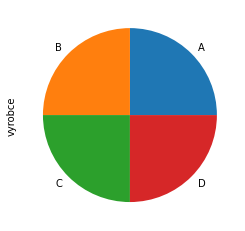

In [8]:
# koláčový graf
aku['vyrobce'].value_counts().plot.pie()

<AxesSubplot:>

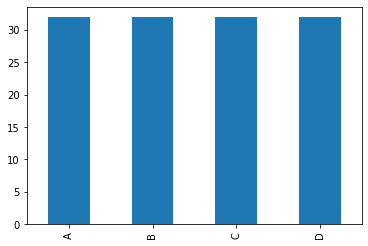

In [9]:
# sloupcový graf
aku['vyrobce'].value_counts().plot.bar()

## Explorační analýza kvantitativních proměnných

In [10]:
# základní numerické charakteristiky
aku.describe()

,kapacita_5,kapacita_100
count,128.00000,128.000000
mean,1987.93750,1828.492188
std,142.30309,179.292529
min,732.00000,620.000000
25%,1969.75000,1773.500000
50%,2005.00000,1846.000000
75%,2041.25000,1928.250000
max,2129.00000,2134.000000


<AxesSubplot:ylabel='Frequency'>

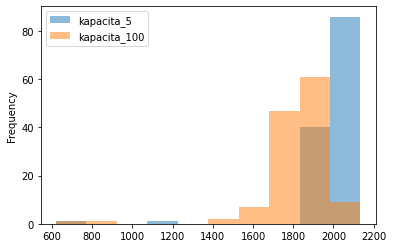

In [11]:
# histogramy
aku.plot.hist(alpha=0.5)

<AxesSubplot:>

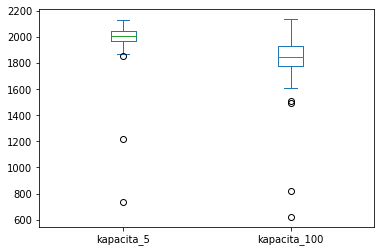

In [12]:
# krabicové grafy
aku.plot.box()

In [13]:
# výpis řádků obsahujících odlehlá pozorování (podle metody vnitřních hradeb)
Q1_5=aku['kapacita_5'].quantile(0.25)
Q3_5=aku['kapacita_5'].quantile(0.75)
IQR_5 = Q3_5-Q1_5
out_5 = (aku['kapacita_5']<(Q1_5-1.5*IQR_5)) | (aku['kapacita_5']>(Q3_5+1.5*IQR_5))
aku[out_5]

,vyrobce,kapacita_5,kapacita_100
cislo,,,
20,A,732,620
33,B,1854,1841
88,C,1221,823


In [14]:
# odstraníme řádky s kapacitami pod 1500 mAh 
aku = aku[(aku['kapacita_5']>=1500)|(aku['kapacita_100']>=1500)].copy()

<AxesSubplot:ylabel='Frequency'>

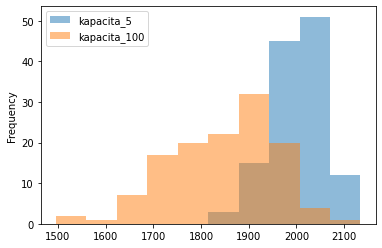

In [15]:
aku.plot.hist(alpha=0.5)

<AxesSubplot:>

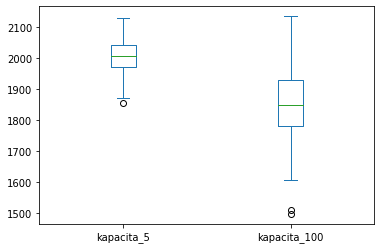

In [16]:
aku.plot.box()

In [17]:
# základní charakteristiky pro data očištěná od odlehých pozorování
aku.describe()

,kapacita_5,kapacita_100
count,126.000000,126.000000
mean,2003.992063,1846.063492
std,54.678917,112.148027
min,1854.000000,1496.000000
25%,1970.250000,1778.500000
50%,2006.500000,1846.500000
75%,2041.750000,1928.750000
max,2129.000000,2134.000000


## Závislost dvou kvantitativních proměnných

<AxesSubplot:xlabel='kapacita_5', ylabel='kapacita_100'>

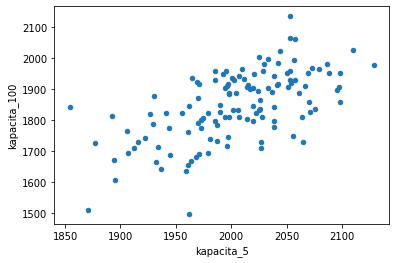

In [18]:
# bodový graf závislosti kapacit po 5 a kapacit po 100 cyklech
aku.plot.scatter(x='kapacita_5', y='kapacita_100')
# z rozložení bodů v grafu lze usoudit, že hodnoty kapacit po 5 a po 100 cyklech jsou vzájemně závislé

In [19]:
# Pearsonův korelační koeficient
aku.corr()

,kapacita_5,kapacita_100
kapacita_5,1.000000,0.614853
kapacita_100,0.614853,1.000000


## Explorační analýza závislosti kvantitativní a kategoriální proměnné

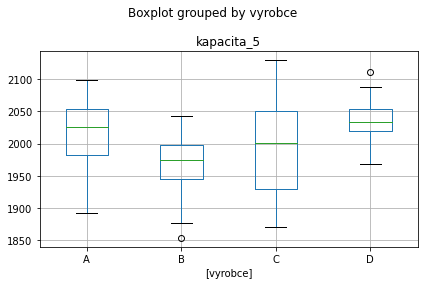

In [20]:
# krabicov graf kapacity po 5 cyklech v zavislosti na vyrobci
aku.boxplot(column=['kapacita_5'], by=['vyrobce']);
plt.tight_layout() # upravi mezery kolem grafu
# výrazné posunutí krabicových grafů (např. B proti D) naznačuje závislost kapacity po 5 cyklech na výrobci

## Explorační analýza závislosti dvou kvantitativních proměnných

In [81]:
# pokles kapacit mezi 5. a 100. cyklem
aku['pokles']=aku['kapacita_5']-aku['kapacita_100']

In [82]:
# relativní pokles
aku['rel_pokles']=aku['pokles']/aku['kapacita_5']

In [83]:
# je relativní pokles > 0.1 ?
aku['pokles_nad10p'] = aku['rel_pokles']>0.1

In [84]:
# kontingenční tabulka (tabulka absolutních četností dvojic (výrobce, pokles > 0.1))
crt = pd.crosstab(aku['vyrobce'], aku['pokles_nad10p'])

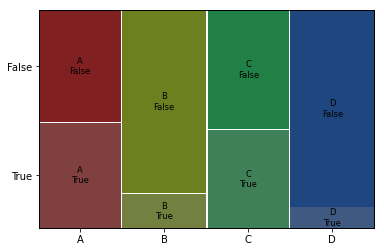

In [85]:
# mozaikový graf (grafické znázornění kontingeční tabulky)
mosaic(aku, ['vyrobce', 'pokles_nad10p']);
# výrazně rozdílné poměry výšek buněk v jednotlivých sloupcích nazačují závislsot mezi poklesem a výrobcem

## Ověření normality 

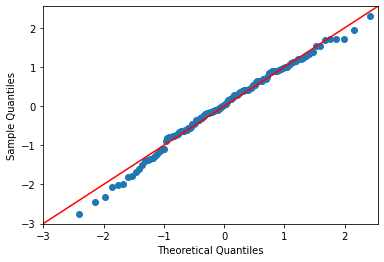

In [26]:
# pomocí QQ grafu
sm.qqplot(aku['kapacita_5'], line='45', fit=True)
plt.show()
# rozložení bodů podél přímky ukazuje na normální rozdělení dat

In [27]:
# normalitu lze testovat např. Shapirovým-Wilkovým testem (H0: data mají normální rozdělení, H1: negace H0)
stats.shapiro(aku['kapacita_5'])
# vyspoká p-hodnota ukazuje, že data nevykazují významnou odchylku od normality 

ShapiroResult(statistic=0.9879963397979736, pvalue=0.3384783864021301)

# Testy hypotéz

## Ověření normality pro jednotlivé kapacity a výrobce

In [109]:
aku[['kapacita_5', 'vyrobce']].groupby('vyrobce').apply(stats.shapiro)

vyrobce
A     (0.9721419215202332, 0.5797627568244934)
B    (0.9383649826049805, 0.06728947162628174)
C     (0.9658653736114502, 0.4130503237247467)
D     (0.9861747026443481, 0.9459457397460938)
dtype: object

In [110]:
aku[['kapacita_100', 'vyrobce']].groupby('vyrobce').apply(stats.shapiro)

vyrobce
A     (0.9885702729225159, 0.9796796441078186)
B     (0.9734573364257812, 0.5997429490089417)
C    (0.9675898551940918, 0.45529457926750183)
D     (0.9814878106117249, 0.8415166735649109)
dtype: object

Všechny p-hodnoty jsou vyšší než 0.05. Jednotlivé výběry můžeme považovat za výbery z normálního rozdělení.

## Dosahují akumulátory výrobce A po 5 cyklech deklarované kapacity?

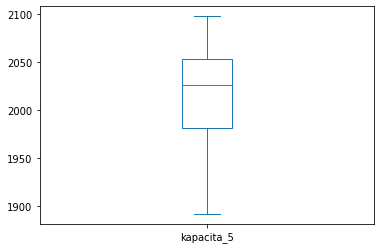

In [28]:
kap5A = aku['kapacita_5'][aku['vyrobce']=='A']
kap5A.plot.box();
# krabicový graf nenaznačuje odchylku od deklarované hodnoty

H0: $\mu_A=2000$, H1: $\mu_A\neq 2000$

In [29]:
# jednovýběrový t-test
stats.ttest_1samp(kap5A, popmean=2000)

Ttest_1sampResult(statistic=1.8797445611822208, pvalue=0.06988635487346818)

t-test: p-hodnota=0.07

Na hladině významnosti 0.05 nezamítáme H0. U akumumulátorů výrobce A po 5 cyklech nebyla prokázána odchyka kapacity od deklarované kapacity.

---

## Liší se střední hodnoty kapacit akuamulátorů výrobců B a D po 100 cyklech?

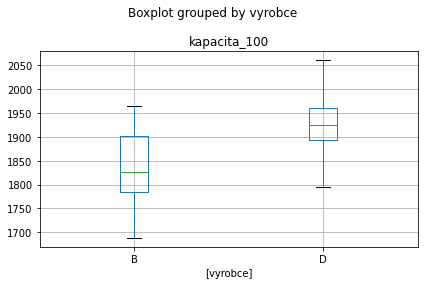

In [36]:
# vybere pouze aku vyrobcu B a D a vykresli krabicove grafy 
aku[aku['vyrobce'].isin(['B', 'D'])].boxplot(column=['kapacita_100'], by=['vyrobce'])
plt.tight_layout()


([<matplotlib.axis.XTick at 0x7f062e793190>,
 [Text(1, 0, 'B'), Text(2, 0, 'D')])

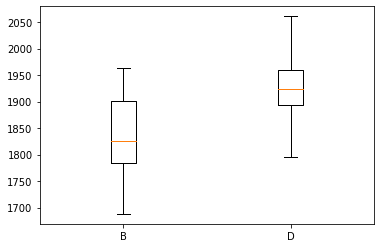

In [46]:
kapB100 = aku['kapacita_100'][aku['vyrobce']=='B']
kapD100 = aku['kapacita_100'][aku['vyrobce']=='D']

# krabicové grafy pomocí matplotlib
plt.boxplot([kapB100, kapD100])
plt.xticks(ticks=[1, 2], labels=['B', 'D'])

Krabicové grafy naznačují, že kapacity akamulátorů výrobce D jsou vyšší než výrobce B.

H0: $\mu_B=\mu_D$, H1: $\mu_B<\mu_D$

In [69]:
# dvouvýběrový t-test
test = stats.ttest_ind(kapB100, kapD100)
print("Dvouvýběrový t-test: p-hodnota={:f}".format(test.pvalue))

Dvouvýběrový t-test: p-hodnota=0.000003


Na hladině významnosti 0.05 zamítáme H0. Střední hodnoty kapacit po 100 cyklech akumulátorů výrobce D jsou vyšší než střední hodnoty kapacit akumulátorů výrobce B.

---

## Liší se rozptyly hodnoty kapacit akuamulátorů výrobců B a D po 100 cyklech?

H0: $\sigma_B^2=\sigma_D^2$, H1: $\sigma_B^2>\sigma_D^2$

In [70]:
SB100 = kapB100.var()
SD100 = kapD100.var()
F = SB100/SD100
pval = 1-stats.f.cdf(F, len(kapB100)-1, len(kapD100)-1)
print("F-test: p-hodnota={:f}".format(pval))

F-test: p-hodnota=0.225281


Na hladině významnosti 0.05 nezamítáme H0. U akamulátorů výrobců B a D nebyl po 100 cyklech prokázán rozdíl v rozptylech kapacit.

---

## Liší se kapacity akumulátorů výrobce A po 5 a po 100 cyklech?

POZOR: Nejde o nezávislé výběry! Data jsou párová. Posuzujeme stř. hodnotu rozdílů po 5 a po 100 cyklech.

<AxesSubplot:>

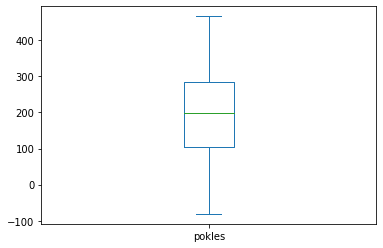

In [94]:
aku['pokles'][aku['vyrobce']=='A'].plot.box()

Střední hodnota poklesu kapacity: $\mu_{pA}$

H0: $\mu_{pA}=0$, H1: $\mu_{pA}>0$  

In [95]:
# Chybně (jako nezávislá data):
stats.ttest_ind(aku['kapacita_5'][aku['vyrobce']=='A'], aku['kapacita_100'][aku['vyrobce']=='A'])

Ttest_indResult(statistic=7.286911761098858, pvalue=8.09863597361896e-10)

In [96]:
# Správně pomocí párového t-testu (jako párová data):
stats.ttest_rel(aku['kapacita_5'][aku['vyrobce']=='A'], aku['kapacita_100'][aku['vyrobce']=='A'])

Ttest_relResult(statistic=9.069757105924472, pvalue=4.2254100561459184e-10)

In [98]:
# Správně pomocí jednovýběrového t-testu:
stats.ttest_1samp(aku['pokles'][aku['vyrobce']=='A'], popmean=0)

Ttest_1sampResult(statistic=9.069757105924472, pvalue=4.2254100561459184e-10)

Na hladině významnosti 0.05 zamítáme H0. U akamulátorů výrobce A dochází mezi 5 a 100 cyklem k poklesu stř. hoodnoty kapacity.

---

## Intervalové odhady stř. hodot kapacit po 5 cyklech

In [129]:
alfa = 0.05
z = stats.norm.ppf(1-alfa/2, 0, 1)  
for v in aku['vyrobce'].unique():
    aku_v =  aku['kapacita_5'][aku['vyrobce']==v]
    m = aku_v.mean() # výběrový průměr
    s = aku_v.std()  # výběrová směrodatná odchylka
    d = z*s/len(aku_v)**0.5 # polovina délky konfidenčního intervalu
    td = m-d # dolní mez
    th = m+d # horn9 mez
    print('výrobce {}: ({:.0f}, {:.0f}) mAh'.format(v, td, th))

výrobce A: (1999, 2034) mAh
výrobce B: (1955, 1984) mAh
výrobce C: (1972, 2021) mAh
výrobce D: (2022, 2044) mAh


In [130]:
stats.ttest_ind?

Signature:
stats.ttest_ind(
    a,
    b,
    axis=0,
    equal_var=True,
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided',
    trim=0,
)
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, optional
    Axis along which to compute test. If None, compute over the whole
    arrays, `a`, and `b`.
equal_var : bool, optional
    If True (default), perform a standard independent 2 sample test
    that assumes equal population variances [1]_.
    If False, perform Welch's t-test, which does not assume equal
    population variance [2]_.

  